# Secondary Analyses evaluates within-group variation to understand biological variability at each dose.

Performing: Brown-Forsyth, OLS, HC3 (Heteroskedasticity) Robust Standard Errors, AIC Model Selection, Spearman Rank Correlation

### Importing the necessary libraries needed to perform Secondary Analyses 

In [2]:
import os
import numpy as np
import pandas as pd

from pathlib import Path
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib.patches import  Rectangle

# For Female Mice

## Load Dataset

In [3]:
project = Path.cwd().parents[1]
clean_dir = project /"01_data" / "02_clean" 
clean_csv = clean_dir / "final_microglial_counts_cleaned.csv"
clean_df = pd.read_csv(clean_csv)

# types + tidy text
clean_df["Dose"] = pd.to_numeric(clean_df["Dose"], errors="coerce")
clean_df["Microglial_Count"] = pd.to_numeric(clean_df["Microglial_Count"], errors="coerce")
clean_df["Sex"] = clean_df["Sex"].astype(str).str.strip().str.capitalize()

# female mice only
female_df = clean_df.query("Sex == 'Female'").dropna(subset=["Dose","Microglial_Count"]).copy()
female_df.sort_values(["Dose","Mouse_ID"], inplace=True)

print("Female mice per dose:")
print(female_df.groupby("Dose")["Mouse_ID"].nunique())

Female mice per dose:
Dose
0       4
100     4
300     4
600     3
900     4
1200    4
Name: Mouse_ID, dtype: int64


## Per-dose summary (mean, SD, 95% CI, CV)
Describe each dose: center (mean/median) and spread (SD, CV, 95% CI). Shows the shape of the data.

In [1]:
# function created to calculate mean, SD, 95% CI
def summarize_counts(g):
    x = g["Microglial_Count"].to_numpy()
    n = x.size
    mean = np.mean(x)
    sd   = np.std(x, ddof=1) if n > 1 else np.nan
    sem  = sd/np.sqrt(n) if n > 1 else np.nan
    if n > 1:
        tval = stats.t.ppf(0.975, n-1)
        ci_lo, ci_hi = mean - tval*sem, mean + tval*sem
    else:
        ci_lo = ci_hi = np.nan
    cv = (sd/mean) if (n > 1 and mean != 0) else np.nan
    return pd.Series({
        "N": n, "Mean": mean, "SD": sd, "SEM": sem,
        "Lower CI": ci_lo, "Upper CI": ci_hi, "CV": cv,
        "Median": np.median(x), "Q1": np.quantile(x,0.25), "Q3": np.quantile(x,0.75),
        "Min": np.min(x), "Max": np.max(x)
    })

N: number of mice in that dose group.
Mean: average microglial count.
SD: standard deviation = how spread out the counts are.
Formula: √(Σ(x − mean)² / (n − 1))
SEM: standard error of the mean = sd / √n (uncertainty of the mean).

Lower CI / Upper CI: lower/upper ends of the 95% confidence interval for the mean.
Computed as: mean ± t_{0.975, n−1} × sem

CV: coefficient of variation = sd / mean 
A scale-free measure of variability.

Median: middle value (half above, half below); robust to outliers.

Q1 / Q3: 1st and 3rd quartiles = 25th and 75th percentiles.

Min / Max: smallest and largest observed counts in the group.

In [5]:
# applying function to female mice
summ_female = female_df.groupby("Dose", as_index=False).apply(summarize_counts, include_groups=False)
summ_female.reset_index(drop=True, inplace=True)
summ_female

,Dose,N,Mean,SD,SEM,Lower CI,Upper CI,CV,Median,Q1,Q3,Min,Max
0,0,4.0,4674.000000,1737.165315,868.582658,1909.782330,7438.217670,0.371666,4835.0,3537.25,5971.75,2650.0,6376.0
1,100,4.0,4912.250000,1727.241418,863.620709,2163.823465,7660.676535,0.351619,4716.0,3772.50,5855.75,3144.0,7073.0
2,300,4.0,2878.500000,1839.302857,919.651429,-48.241291,5805.241291,0.638980,2813.5,2028.00,3664.00,720.0,5167.0
3,600,3.0,1703.666667,694.934769,401.220776,-22.647000,3429.980334,0.407905,1986.0,1449.00,2099.50,912.0,2213.0
4,900,4.0,1394.000000,697.712453,348.856226,283.783791,2504.216209,0.500511,1315.0,992.50,1716.50,652.0,2294.0
5,1200,4.0,596.750000,195.993835,97.996917,284.880072,908.619928,0.328435,690.5,588.75,698.50,303.0,703.0


In [6]:
# save results as a CSV file
summ_female.to_csv(clean_dir / "per_dose_female_summary.csv", index=False)

## Variability within groups (Brown–Forsythe / Levene median-centered)
Prior to regression, will test wheter within-dose variances are equal. This matter because OLS' usual standard error assumes constant variance.

**Why?** Robust to non-normality/outlier are unequal group sizes - fits small-n biology

In [6]:
print("Variability Across Doses (Females Only) — Brown–Forsythe (median-centered Levene)")

groups = [g["Microglial_Count"].to_numpy() for _, g in female_df.groupby("Dose")]
if len(groups) >= 2 and all(len(g) >= 2 for g in groups):
    W, p_bf = stats.levene(*groups, center="median")
    print(f"Brown–Forsythe (variance equality): W={W:.3f}, p={p_bf:.4g}")
else:
    p_bf = np.nan
    print("Brown–Forsythe skipped (need ≥2 groups with ≥2 observations each).")  

Variability Across Doses (Females Only) — Brown–Forsythe (median-centered Levene)
Brown–Forsythe (variance equality): W=2.862, p=0.04712


Brown–Forsythe (median-centered Levene) indicated unequal within-dose variances (W = 2.862, p = 0.047). Because the equal-variance assumption is questionable, downstream regression inference is reported with HC3 heteroscedasticity-robust standard errors. This choice makes p-values and confidence intervals valid even if variability differs by dose.

In [16]:
# function created to save Brown-Forsythhe results to Dataframe and then to CSV file
def save_bf_result(sex_label: str, W_value, p_value, filename: str):
    row = {
        "Sex": sex_label,
        "W":   float(W_value) if pd.notna(W_value) else np.nan,
        "p":   float(p_value) if pd.notna(p_value) else np.nan,}
    out = pd.DataFrame([row])
    out.to_csv(clean_dir / filename, index=False)

In [17]:
# save the Brown-Forsythe results for female mice as a CSV file
save_bf_result("Female", W, p_bf, "brown_forsythe_female.csv")

## Dose trend (linear OLS, HC3 robust SE, quadratic check, Spearman)

In [9]:
# linear: Microglial_Count ~ Dose
m_lin = smf.ols("Microglial_Count ~ Dose", data=female_df).fit()
print(m_lin.summary())

# 95% CI for slope
slope = m_lin.params["Dose"]
ci_lo, ci_hi = m_lin.conf_int().loc["Dose"].tolist()
print(f"Slope (per mg/kg): {slope:.4g}  95% CI [{ci_lo:.4g}, {ci_hi:.4g}]  p={m_lin.pvalues['Dose']:.4g}")

#HC3 robust standard errors
m_lin_hc3 = m_lin.get_robustcov_results(cov_type="HC3")

dose_ix = list(m_lin.params.index).index("Dose")
rob_slope = float(m_lin_hc3.params[dose_ix])
rob_se = float(m_lin_hc3.bse[dose_ix])

conf = m_lin_hc3.conf_int()
rob_ci_lo = float(conf[dose_ix, 0])
rob_ci_hi = float(conf[dose_ix, 1])

rob_p = float(m_lin_hc3.pvalues[dose_ix])

print("=== Robust SE (HC3) for OLS dose effect ===")
print(f"Slope (per mg/kg): {rob_slope:.4g}")
print(f"HC3 SE={rob_se:.4g}  95% CI [{rob_ci_lo:.4g}, {rob_ci_hi:.4g}]  p={rob_p:.4g}")

# quadratic check
female_df["Dose2"] = female_df["Dose"]**2
m_quad = smf.ols("Microglial_Count ~ Dose + Dose2", data=female_df).fit()
print(f"AIC linear={m_lin.aic:.2f}  |  AIC quadratic={m_quad.aic:.2f}")
if m_quad.aic + 2 < m_lin.aic:
    print("Quadratic fits meaningfully better (ΔAIC > 2).")
else:
    print("Linear looks sufficient (ΔAIC ≤ 2).")

# nonparametric monotonic trend
rho, p_spear = stats.spearmanr(female_df["Dose"], female_df["Microglial_Count"])
print(f"Spearman rho={rho:.3f}, p={p_spear:.4g}")

                            OLS Regression Results                            
Dep. Variable:       Microglial_Count   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     33.22
Date:                Mon, 08 Sep 2025   Prob (F-statistic):           1.01e-05
Time:                        00:41:50   Log-Likelihood:                -196.73
No. Observations:                  23   AIC:                             397.5
Df Residuals:                      21   BIC:                             399.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4581.4297    421.235     10.876      0.0

In [10]:
# function created to save OLS Regression Results to a text file
def save_ols(result, prefix: str, *, dose_term: str = "Dose", quad_result=None, spearman=None):
    # summary
    lines = [result.summary().as_text(), ""]
    # HC3 robust stats for the dose term
    rob = result.get_robustcov_results(cov_type="HC3")
    # locate the dose term index safely
    if hasattr(result, "params") and dose_term in result.params.index:
        ix = list(result.params.index).index(dose_term)
    else:
        names = getattr(result.model, "exog_names", [])
        ix = names.index(dose_term) if dose_term in names else None

    if ix is not None:
        # regular slope & CI
        slope = float(result.params[dose_term])
        ci_lo, ci_hi = [float(x) for x in result.conf_int().loc[dose_term].tolist()]
        p_lin = float(result.pvalues[dose_term])

        # HC3 robust slope/SE/CI/p
        import numpy as np
        rob_slope = float(np.asarray(rob.params)[ix])
        rob_se    = float(np.asarray(rob.bse)[ix])
        ci_rob    = np.asarray(rob.conf_int(), dtype=float)[ix]
        rob_ci_lo = float(ci_rob[0]); rob_ci_hi = float(ci_rob[1])
        rob_p     = float(np.asarray(rob.pvalues)[ix])

        lines += [
            "=== Robust SE (HC3) for OLS dose effect ===",
            f"Slope (per mg/kg): {rob_slope:.4g}",
            f"HC3 SE={rob_se:.4g}  95% CI [{rob_ci_lo:.4g}, {rob_ci_hi:.4g}]  p={rob_p:.4g}",
            "",
            f"Slope (per mg/kg): {slope:.4g}  95% CI [{ci_lo:.4g}, {ci_hi:.4g}]  p={p_lin:.4g}",
        ]
    else:
        lines += ["[WARN] Dose term not found; skipping HC3/dose lines."]

    # AICs
    aic_lin = float(result.aic)
    if quad_result is not None:
        aic_quad = float(quad_result.aic)
        note = "Quadratic fits meaningfully better (ΔAIC > 2)." if (aic_quad + 2 < aic_lin) \
               else "Linear looks sufficient (ΔAIC ≤ 2)."
        lines += [f"AIC linear={aic_lin:.2f}  |  AIC quadratic={aic_quad:.2f}", note]
    else:
        lines += [f"AIC linear={aic_lin:.2f}"]

    # Spearman
    if spearman is not None:
        rho, p = spearman
        lines += [f"Spearman rho={float(rho):.3f}, p={float(p):.4g}"]

    # 5) write once
    txt_path = clean_dir / f"{prefix}_summary.txt"
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines) + "\n")


In [11]:
# save text file for female mice
save_ols(m_lin, "ols_female", quad_result=m_quad, spearman=(rho, p_spear))

# Visualizations for Female Mice

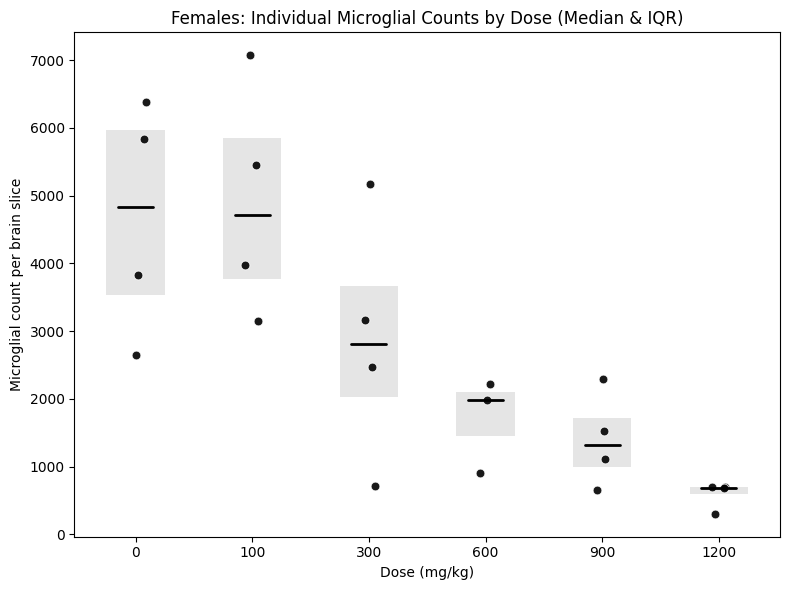

In [14]:
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "secondary"
fig_path = save_dir / "females_counts_median_IQR.png"

plt.figure(figsize=(8,6))
ax = plt.gca()

doses = sorted(female_df['Dose'].dropna().unique())
xpos = {d: i for i, d in enumerate(doses)}  

# draw an IQR "band" 
for d in doses:
    row = summ_female.loc[summ_female["Dose"]==d].iloc[0]
    xm  = xpos[d]
    q1, q3 = row["Q1"], row["Q3"]
    
    ax.add_patch(Rectangle(
            (xm-0.25, q1), #left, bottom
            0.5, q3-q1, #width, height
            facecolor = "black", # color choice
            edgecolor = "none",  
            alpha=0.10, # transparency so dots are readable
            zorder=1))
    
    med = row["Median"]
    ax.plot([xm-0.15, xm+0.15], [med, med], color="black", lw=2, solid_capstyle="round", zorder=6)

# points 
rng = np.random.default_rng(44)
x = female_df["Dose"].map(xpos).to_numpy() + rng.normal(0, 0.06, size=len(female_df))
plt.scatter(
    x, female_df["Microglial_Count"], 
    color="black",
    s=40,
    alpha=0.9,
    edgecolor="white", linewidth=0.6, zorder=3)

plt.xticks(list(xpos.values()), [str(int(d)) for d in doses])
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Microglial count per brain slice")
plt.title("Females: Individual Microglial Counts by Dose (Median & IQR)")

plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()


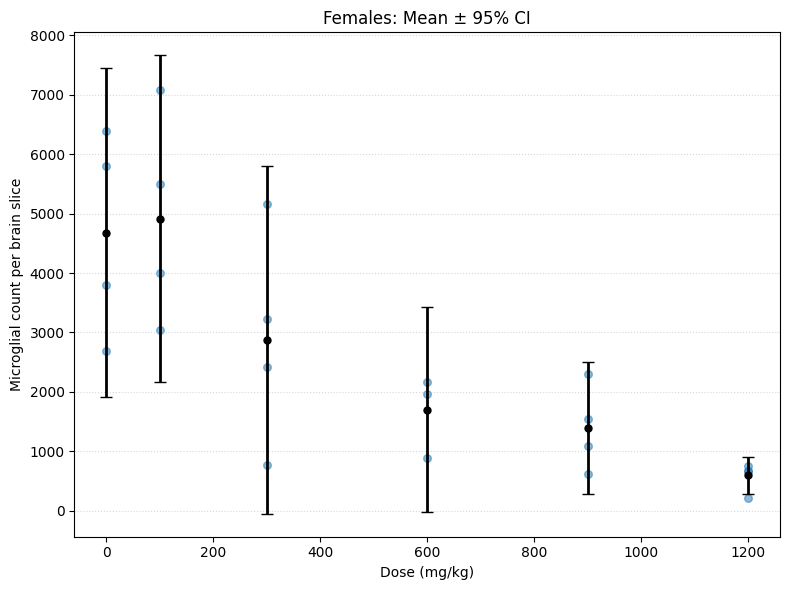

In [18]:
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "secondary"
fig_path = save_dir / "females_counts_mean_CI.png"

# plot for female mice
plt.figure(figsize=(8,6))

# raw points
rng = np.random.default_rng(43)
y_jitter = rng.normal(0, 50, size=len(female_df))  # jitter ~50 counts
plt.scatter(female_df["Dose"], female_df["Microglial_Count"] + y_jitter, alpha=0.5, s=30)

summary_color = "black"

for d in sorted(summ_female["Dose"].unique()):
    row = summ_female.loc[summ_female["Dose"]==d].iloc[0]
    mu, lo, hi = row["Mean"], row["Lower CI"], row["Upper CI"]

    if np.isfinite(lo) and np.isfinite(hi):
        yerr = [[mu - lo], [hi - mu]]  # [lower_err, upper_err]
        plt.errorbar(d, mu, yerr=yerr, fmt="o", color=summary_color,
                     capsize=4, elinewidth=2, markersize=5, zorder=4)
    else:
        plt.plot(d, mu, "o", color=summary_color, zorder=4)

plt.xlabel("Dose (mg/kg)")
plt.ylabel("Microglial count per brain slice")
plt.title("Females: Mean ± 95% CI")
plt.grid(axis="y", linestyle=":", alpha=0.5)

plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()

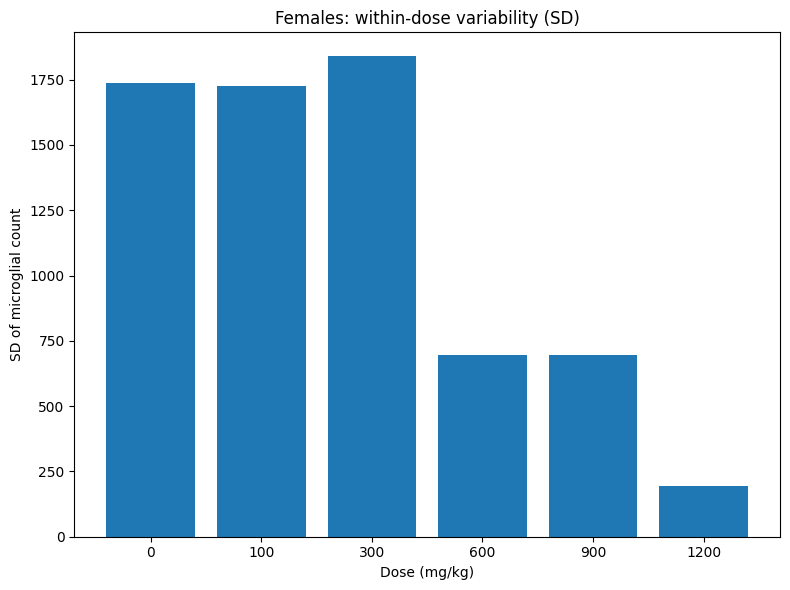

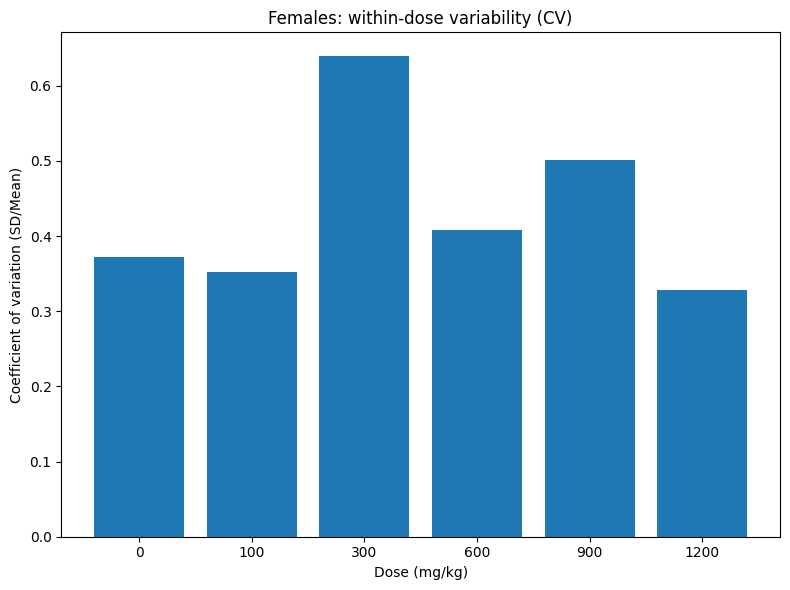

In [19]:
# SD and CV bar charts
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "secondary"
fig_path1 = save_dir / "females_within_dose_SD.png"
fig_path2 = save_dir / "females_within_dose_CV.png"

fig = plt.figure(figsize=(8,6))
plt.bar(range(1, len(doses)+1), summ_female["SD"].to_numpy())
plt.xticks(list(range(1, len(doses)+1)), [str(int(d)) for d in doses])
plt.xlabel("Dose (mg/kg)")
plt.ylabel("SD of microglial count")
plt.title("Females: within-dose variability (SD)")

plt.tight_layout()
plt.savefig(fig_path1, dpi=300)
plt.show()

fig = plt.figure(figsize=(8,6))
plt.bar(range(1, len(doses)+1), summ_female["CV"].to_numpy())
plt.xticks(list(range(1, len(doses)+1)), [str(int(d)) for d in doses])
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Coefficient of variation (SD/Mean)")
plt.title("Females: within-dose variability (CV)")

plt.tight_layout()
plt.savefig(fig_path2, dpi=300)
plt.show()


# For Male Mice

## Load Dataset

In [7]:
project = Path.cwd().parents[1]
clean_dir = project /"01_data" / "02_clean" 
clean_csv = clean_dir / "final_microglial_counts_cleaned.csv"
clean_df = pd.read_csv(clean_csv)

# types + tidy text
clean_df["Dose"] = pd.to_numeric(clean_df["Dose"], errors="coerce")
clean_df["Microglial_Count"] = pd.to_numeric(clean_df["Microglial_Count"], errors="coerce")
clean_df["Sex"] = clean_df["Sex"].astype(str).str.strip().str.capitalize()

# male mice only
male_df = clean_df.query("Sex == 'Male'").dropna(subset=["Dose","Microglial_Count"]).copy()
male_df.sort_values(["Dose","Mouse_ID"], inplace=True)

print("Male mice per dose:")
print(male_df.groupby("Dose")["Mouse_ID"].nunique())

Male mice per dose:
Dose
0       4
900     4
1200    4
Name: Mouse_ID, dtype: int64


## Per-dose summary (mean, SD, 95% CI, CV)
Describe each dose: center (meam/median) and spread (SD, CV, 95% CI). Shows the shape of the data.

In [9]:
male_summ = male_df.groupby("Dose", as_index=False).apply(summarize_counts, include_groups=False)
male_summ.reset_index(drop=True, inplace=True)
male_summ

,Dose,N,Mean,SD,SEM,Lower CI,Upper CI,CV,Median,Q1,Q3,Min,Max
0,0,4.0,6448.50,1680.443295,840.221647,3774.539723,9122.460277,0.260594,6901.0,5853.75,7495.75,4095.0,7897.0
1,900,4.0,2225.75,859.845868,429.922934,857.543347,3593.956653,0.386317,2117.5,1555.00,2788.25,1432.0,3236.0
2,1200,4.0,626.75,650.545092,325.272546,-408.412412,1661.912412,1.037966,467.0,334.25,759.50,23.0,1550.0


In [10]:
# save results as a CSV file
male_summ.to_csv(clean_dir / "per_dose_male_summary.csv", index=False)

## Variability within groups (Brown–Forsythe / Levene median-centered)
Prior to regression, will test wheter within-dose variances are equal. This matter because OLS' usual standard error assumes constant variance.

**Why?** Robust to non-normality/outlier are unequal group sizes - fits small-n biology

In [15]:
print("Variability Across Doses (Males Only) — Brown–Forsythe (median-centered Levene)")

m_groups = [g["Microglial_Count"].to_numpy() for _, g in male_df.groupby("Dose")]
if len(m_groups) >= 2 and all(len(g) >= 2 for g in m_groups):
    W_m, p_bf_m = stats.levene(*m_groups, center="median")
    print(f"Brown–Forsythe (variance equality): W={W_m:.3f}, p={p_bf_m:.4g}")

else:
    p_bf_m = np.nan
    print("Brown–Forsythe skipped (need ≥2 groups with ≥2 observations each).")

Variability Across Doses (Males Only) — Brown–Forsythe (median-centered Levene)
Brown–Forsythe (variance equality): W=1.196, p=0.3463


In [18]:
# save the Brown-Forsythe results for male mice as a CSV file
save_bf_result("Male", W_m, p_bf_m, "brown_forsythe_male.csv")

No strong evidence of different variances (p ≥ 0.05).

## Dose trend (linear OLS, HC3 robust SE, quadratic check, Spearman)

In [19]:
# linear: Microglial_Count ~ Dose
m_lin_m = smf.ols("Microglial_Count ~ Dose", data=male_df).fit()
print(m_lin_m.summary())

# 95% CI for slope
slope = m_lin_m.params["Dose"]
ci_lo, ci_hi = m_lin_m.conf_int().loc["Dose"].tolist()
print(f"Slope (per mg/kg): {slope:.4g}  95% CI [{ci_lo:.4g}, {ci_hi:.4g}]  p={m_lin.pvalues['Dose']:.4g}")

#HC3 robust standard errors
m_lin_m_hc = m_lin_m.get_robustcov_results(cov_type="HC3")

dose_ix = list(m_lin_m.params.index).index("Dose")
rob_slope = float(m_lin_m_hc.params[dose_ix])
rob_se = float(m_lin_m_hc.bse[dose_ix])

conf = m_lin_m_hc.conf_int()
rob_ci_lo = float(conf[dose_ix, 0])
rob_ci_hi = float(conf[dose_ix, 1])

rob_p = float(m_lin_hc3.pvalues[dose_ix])

print("=== Robust SE (HC3) for OLS dose effect ===")
print(f"Slope (per mg/kg): {rob_slope:.4g}")
print(f"HC3 SE={rob_se:.4g}  95% CI [{rob_ci_lo:.4g}, {rob_ci_hi:.4g}]  p={rob_p:.4g}")

# quadratic check
male_df["Dose2"] = male_df["Dose"]**2
m_quad_m = smf.ols("Microglial_Count ~ Dose + Dose2", data=male_df).fit()
print(f"AIC linear={m_lin_m.aic:.2f}  |  AIC quadratic={m_quad_m.aic:.2f}")
if m_quad_m.aic + 2 < m_lin_m.aic:
    print("Quadratic fits meaningfully better (ΔAIC > 2).")
else:
    print("Linear looks sufficient (ΔAIC ≤ 2).")

# nonparametric monotonic trend
rho, p_spear = stats.spearmanr(male_df["Dose"], male_df["Microglial_Count"])
print(f"Spearman rho={rho:.3f}, p={p_spear:.4g}")


                            OLS Regression Results                            
Dep. Variable:       Microglial_Count   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     60.22
Date:                Mon, 08 Sep 2025   Prob (F-statistic):           1.54e-05
Time:                        00:43:15   Log-Likelihood:                -99.925
No. Observations:                  12   AIC:                             203.9
Df Residuals:                      10   BIC:                             204.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6470.5865    537.311     12.043      0.0

In [20]:
# save text file for male mice
save_ols(m_lin, "ols_male", quad_result=m_quad_m, spearman=(rho, p_spear))

# Visualizations for Male Mice

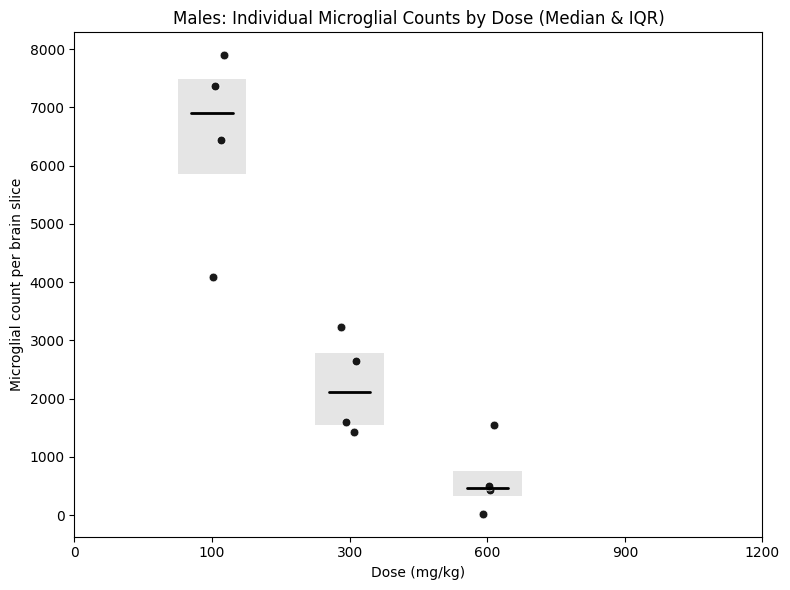

In [27]:
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "secondary"
fig_path = save_dir / "male_counts_median_IQR.png"

plt.figure(figsize=(8,6))
ax = plt.gca()

doses_m = np.sort(male_df["Dose"].unique())
xpos_m = {d: i+1 for i, d in enumerate(doses_m)}

# draw an IQR "band" 
for d in doses_m:
    row = male_summ.loc[male_summ["Dose"]==d]
    if row.empty:
        continue
    row = row.iloc[0]
    xm = xpos_m[d]
    q1, q3 = row["Q1"], row["Q3"]
    
    ax.add_patch(Rectangle(
            (xm-0.25, q1), #left, bottom
            0.5, q3-q1, #width, height
            facecolor = "black", # color choice
            edgecolor = "none",  
            alpha=0.10, # transparency so dots are readable
            zorder=1))
    
    med = row["Median"]
    ax.plot([xm-0.15, xm+0.15], [med, med], color="black", lw=2, solid_capstyle="round", zorder=6)

# points 
rng = np.random.default_rng(44)
x = male_df["Dose"].map(xpos_m).to_numpy() + rng.normal(0, 0.06, size=len(male_df))
plt.scatter(x, male_df["Microglial_Count"], 
    color="black",
    s=40,
    alpha=0.9,
    edgecolor="white", linewidth=0.6, zorder=3)

plt.xticks(list(xpos.values()), [str(int(d)) for d in doses])
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Microglial count per brain slice")
plt.title("Males: Individual Microglial Counts by Dose (Median & IQR)")

plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()


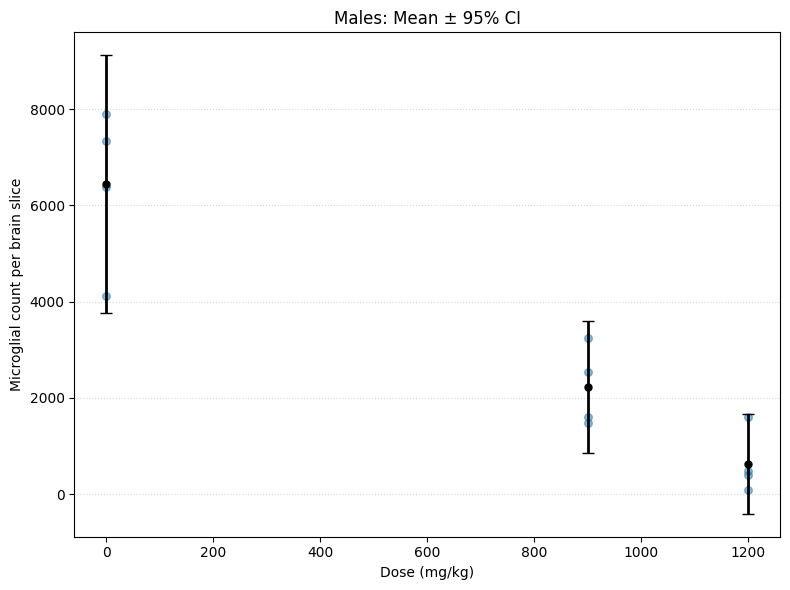

In [21]:
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "secondary"
fig_path = save_dir / "male_counts_mean_CI.png"

# plot for male mice
plt.figure(figsize=(8,6))

# points
rng = np.random.default_rng(43)
y_jitter = rng.normal(0, 50, size=len(male_df))  # jitter ~50 counts
plt.scatter(male_df["Dose"], male_df["Microglial_Count"] + y_jitter, alpha=0.5, s=30)

summary_color = "black"

# overlay male group mean and 95% CI
for d in sorted(male_summ["Dose"].unique()):
    row = male_summ.loc[male_summ["Dose"]==d].iloc[0]
    mu, lo, hi = row["Mean"], row["Lower CI"], row["Upper CI"]

    if np.isfinite(lo) and np.isfinite(hi):
        yerr = [[mu - lo], [hi - mu]]  # [lower_err, upper_err]
        plt.errorbar(d, mu, yerr=yerr, fmt="o", color=summary_color,
                     capsize=4, elinewidth=2, markersize=5, zorder=4)
    else:
        plt.plot(d, mu, "o", color=summary_color, zorder=4)


plt.xlabel("Dose (mg/kg)")
plt.ylabel("Microglial count per brain slice")
plt.title("Males: Mean ± 95% CI")
plt.grid(axis="y", linestyle=":", alpha=0.5)

plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()


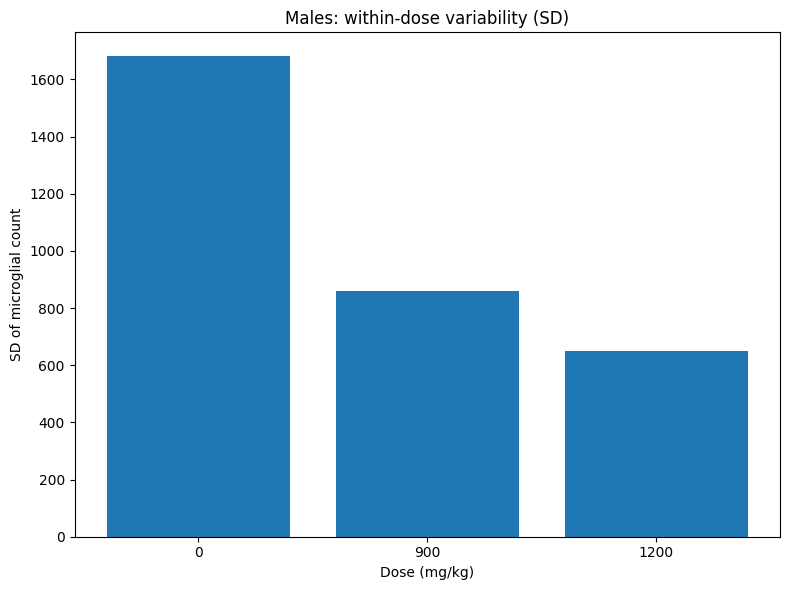

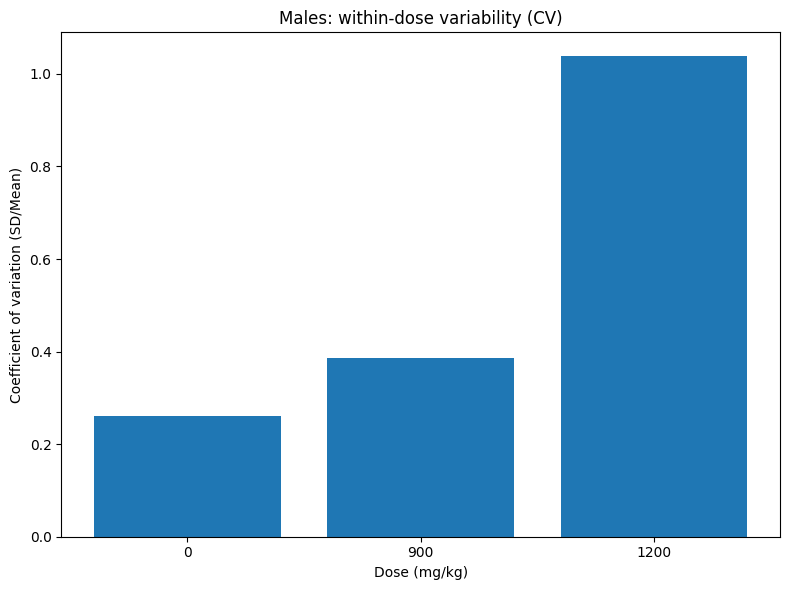

In [29]:
# SD and CV bar charts
# where the visual will be saved
project  = Path.cwd().parents[1] 
save_dir = project / "02_analysis" / "04_visualizations" / "secondary"
fig_path1 = save_dir / "males_within_dose_SD.png"
fig_path2 = save_dir / "males_within_dose_CV.png"

fig = plt.figure(figsize=(8,6))
plt.bar(range(1, len(doses_m)+1), male_summ.set_index("Dose").loc[doses_m, "SD"].to_numpy())
plt.xticks(list(range(1, len(doses_m)+1)), [str(int(d)) for d in doses_m])
plt.xlabel("Dose (mg/kg)")
plt.ylabel("SD of microglial count")
plt.title("Males: within-dose variability (SD)")

plt.tight_layout()
plt.savefig(fig_path1, dpi=300)
plt.show()

fig = plt.figure(figsize=(8,6))
plt.bar(range(1, len(doses_m)+1), male_summ.set_index("Dose").loc[doses_m, "CV"].to_numpy())
plt.xticks(list(range(1, len(doses_m)+1)), [str(int(d)) for d in doses_m])
plt.xlabel("Dose (mg/kg)")
plt.ylabel("Coefficient of variation (SD/Mean)")
plt.title("Males: within-dose variability (CV)")

plt.tight_layout()
plt.savefig(fig_path2, dpi=300)
plt.show()
